<a href="https://colab.research.google.com/github/sjoon0305/KSME2026/blob/main/2. burgers_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

Governing equation:
$$
u_t + uu_x =\nu u_{xx},  \quad x\in [-1, 1], \quad t>0
$$
where $\nu=0.01/\pi$

Initial condition:
$$
u(x,0)=-sin(\pi x)
$$
Boundary condition:
$$
u(-1,t)=u(1,t)=0
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
torch.set_default_dtype(torch.float64)
dtype = torch.float32

In [3]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.nu = torch.tensor(0.01/np.pi)
    self.net = nn.Sequential(
      nn.Linear(2, 40), nn.Tanh(),      
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 40), nn.Tanh(),
      nn.Linear(40, 1)
    )
  def forward(self, x, y):
    data = torch.cat((x,y), dim=1)
    out = self.net(data)
    return out

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [4]:
def fetch_interior_points(domain,batch_size):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x       = data[:,0][:,None]
    y       = data[:,1][:,None]
    return x,y

In [5]:
def residual_loss(model,t,x):
    u = model(t,x)
    u_t, u_x = torch.autograd.grad(u.sum(), (t,x), create_graph=True)
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    loss = (u_t + u*u_x - model.nu*u_xx).pow(2).sum()/x.shape[0]
    return loss

def data_loss(model,x,y,data):
    w = model(x,y)
    loss = (w-data).pow(2).sum()/x.shape[0]
    return loss

In [6]:
# Generate Collocation Points
domain = np.array([[0., -1.],[1., 1.]])
N_domain = 1000
t_dm, x_dm    = fetch_interior_points(domain, N_domain)
t_dm = t_dm.requires_grad_(True)
x_dm = x_dm.requires_grad_(True)

C:\Users\admin\AppData\Local\Temp\ipykernel_5764\2173389795.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]


In [7]:
# Generate Boundary Points
t_e1, x_e1 = fetch_interior_points(np.array([[0., -1.],[1., -1.]]), 100)
t_e2, x_e2 = fetch_interior_points(np.array([[0., 1.],[1., 1.]]), 100)
t_init, x_init = fetch_interior_points(np.array([[0., -1.],[0., 1.]]), 100)
t_bc = torch.cat((t_e1, t_e2), dim = 0).requires_grad_() # boundary condition
x_bc = torch.cat((x_e1, x_e2), dim = 0).requires_grad_() # boundary condition
t_init = t_init.requires_grad_(True)
x_init = x_init.requires_grad_(True)

# Initial condition data
u_init_data = -torch.sin(torch.pi*x_init.detach())

C:\Users\admin\AppData\Local\Temp\ipykernel_5764\2173389795.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]


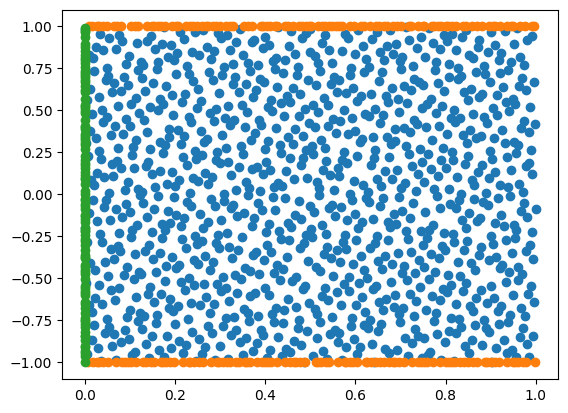

In [8]:
# Check collocation & boundary points
plt.scatter(t_dm.detach().numpy(), x_dm.detach().numpy())
plt.scatter(t_bc.detach().numpy(), x_bc.detach().numpy())
plt.scatter(t_init.detach().numpy(), x_init.detach().numpy())

In [9]:
model = Network()
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_history = {'loss':[]}


In [10]:
n_epochs = 30000

for epoch in range(n_epochs):
  res_loss = residual_loss(model, t_dm, x_dm)
  bc_loss  = data_loss(model, t_bc, x_bc, 0)
  init_loss = data_loss(model, t_init, x_init, u_init_data)
  loss = res_loss + 5*bc_loss + 5*init_loss

  # Save history
  if epoch%10 == 0:
    train_history['loss'].append(float(loss.detach().numpy()))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%1000 ==0:
    print(f'Epoch: {epoch}, Loss: {float(loss):.2}, BC Loss: {float(bc_loss):.3}, Init Loss: {float(init_loss):.3}')



Epoch: 0, Loss: 6.0, BC Loss: 0.211, Init Loss: 0.974
Epoch: 1000, Loss: 0.18, BC Loss: 5.44e-05, Init Loss: 0.00927
Epoch: 2000, Loss: 0.095, BC Loss: 3.95e-05, Init Loss: 0.00477
Epoch: 3000, Loss: 0.052, BC Loss: 4.16e-05, Init Loss: 0.00342
Epoch: 4000, Loss: 0.029, BC Loss: 1.36e-05, Init Loss: 0.00184
Epoch: 5000, Loss: 0.021, BC Loss: 6.19e-06, Init Loss: 0.0013
Epoch: 6000, Loss: 0.017, BC Loss: 4.26e-06, Init Loss: 0.00126
Epoch: 7000, Loss: 0.014, BC Loss: 2.9e-06, Init Loss: 0.0011
Epoch: 8000, Loss: 0.012, BC Loss: 2.1e-06, Init Loss: 0.000977
Epoch: 9000, Loss: 0.01, BC Loss: 2.37e-06, Init Loss: 0.000835
Epoch: 10000, Loss: 0.0091, BC Loss: 1.74e-06, Init Loss: 0.000782
Epoch: 11000, Loss: 0.0088, BC Loss: 4.25e-06, Init Loss: 0.000757
Epoch: 12000, Loss: 0.0092, BC Loss: 1.07e-05, Init Loss: 0.000557
Epoch: 13000, Loss: 0.0071, BC Loss: 6.94e-06, Init Loss: 0.000634
Epoch: 14000, Loss: 0.0076, BC Loss: 8.1e-06, Init Loss: 0.000575
Epoch: 15000, Loss: 0.0055, BC Loss: 2.4

In [11]:
# %matplotlib ipympl
# import matplotlib.pyplot as plt

In [12]:
t_test_domain = np.linspace(0, 1, 200)
x_test_domain = np.linspace(-1, 1, 200)
T_test, X_test = np.meshgrid(t_test_domain, x_test_domain)

U_test = model(torch.from_numpy(T_test).flatten()[:,None], torch.from_numpy(X_test).flatten()[:,None])
U_test = U_test.detach().numpy().reshape(200, 200)

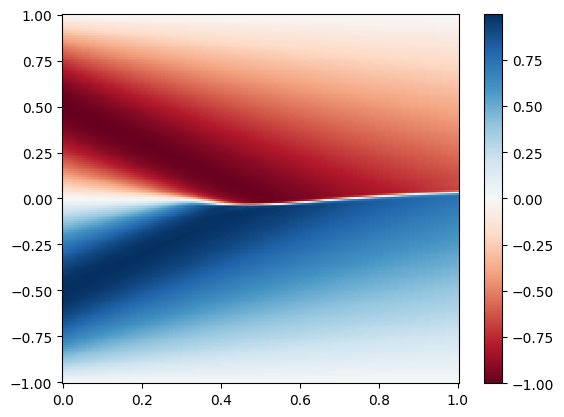

In [13]:
fig, ax = plt.subplots()

p = ax.pcolor(T_test, X_test, U_test, cmap=matplotlib.cm.RdBu, vmin=U_test.min(), vmax=U_test.max())
cb = fig.colorbar(p, ax=ax)